In [1]:
include("../Inversion/Plot.jl")
include("Lorenz96.jl")
include("../Inversion/KalmanInversion.jl");

# Lorenz96 system
Consider the multi-scale Lorenz96 system, with $K$ slow variables $X^{(k)}$ which are each coupled with $J$ fast variables $Y^{(j,k)}$, given by:
\begin{equation}
\label{eq:Lorenz96}
\begin{split}
    &\frac{dX^{(k)}}{dt} = -X^{(k-1)}(X^{(k-2)} - X^{(k+1)}) - X^{(k)} + F - \frac{hc}{d}\sum_{j=1}^{J} Y^{(j,k)}, \\
    &\frac{dY^{(j,k)}}{dt} = -cbY^{(j+1,k)}(Y^{(j+2,k)} - Y^{(j-1,k)}) - cY^{(j,k)} +\frac{hc}{d}X^{k}.
\end{split}
\end{equation}
To close the system, it is appended with the cyclic boundary conditions $X^{(k+K)} = X^{(k)}$, $Y^{(j,k+K)} = Y^{(j,k)}$ and $Y^{(j+J,k)} = Y^{(j,k+1)}$.


The time scale separation is parameterized by the coefficient $c$ and the large-scales are subjected to external forcing $F$.

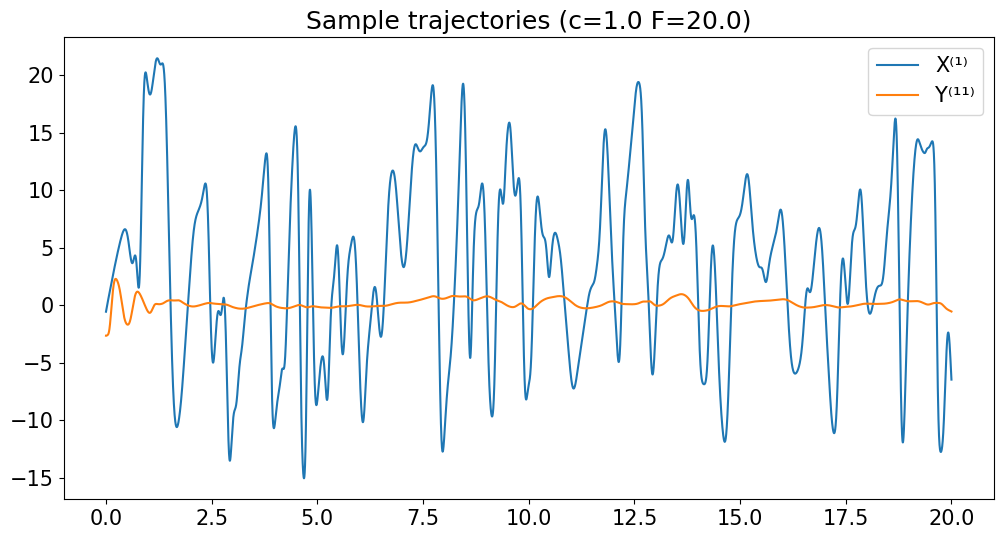

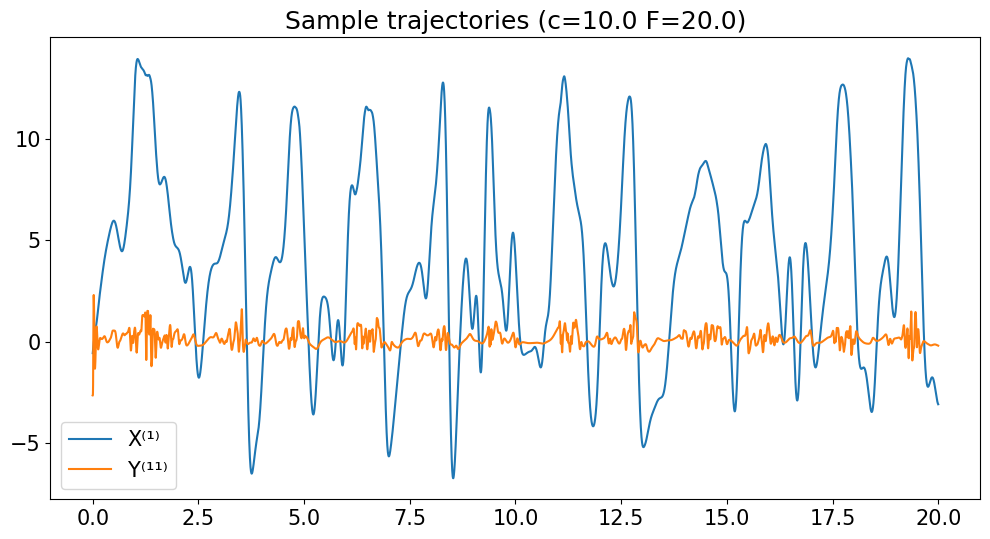

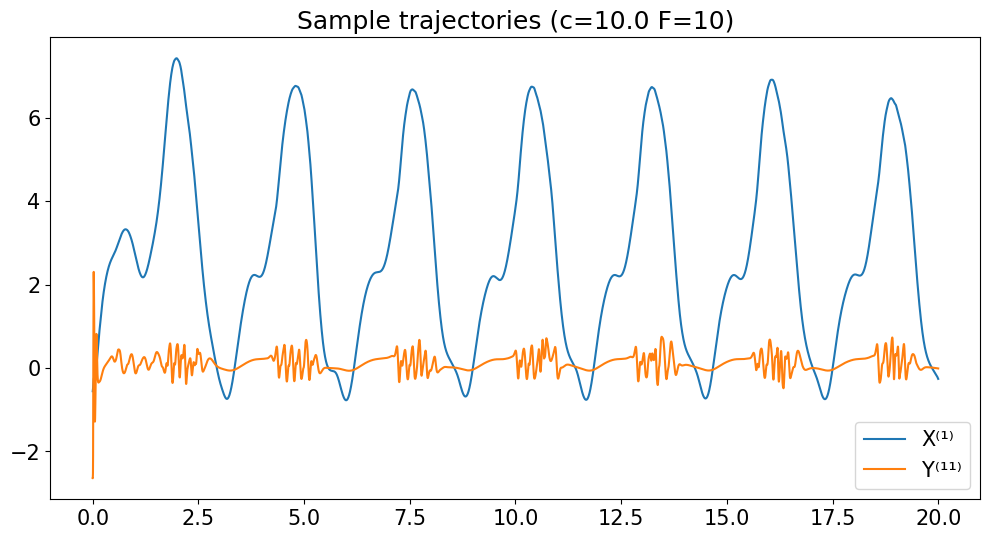

PyObject Text(0.5, 1, 'Sample trajectories (c=10.0 F=10)')

In [2]:
K,  J = 8, 32
F,  h, b = 20.0, 1.0, 10.0
c = 1.0
d = 10.0
T, Δt, RK_order = 20.0, 0.001, 4
obs_type, obs_p = "Statistics", 8
N_θ = 0

# Setup simulation parameters
s_param = Setup_Param(N_θ, K, J, F, h, c, b, d,
                      T, Δt, RK_order, 
                      obs_type, obs_p) 
T, N_t, Δt = s_param.T, s_param.N_t, s_param.Δt
ts = Array(LinRange(0, T, N_t+1)) 
K, J = s_param.K, s_param.J

# Initialization
Random.seed!(42);
Q0 = [rand(Normal(0, 1.0), K) ; rand(Normal(0, 1.0), K*J)]

# Run Multiscale Lorenz96
Qs = run_Lorenz96(s_param, Q0)
# Visulization
figure(figsize=(12,6))
plot(ts, Qs[1, :], label = "X⁽¹⁾")
plot(ts, Qs[K+1, :], label = "Y⁽¹¹⁾")
legend()
title("Sample trajectories (c=$(c) F=$(F))")

########################
c = 10.0
# Setup simulation parameters
s_param.c = c

# Run Multiscale Lorenz96
Qs = run_Lorenz96(s_param, Q0)
# Visulization
figure(figsize=(12,6))
plot(ts, Qs[1, :], label = "X⁽¹⁾")
plot(ts, Qs[K+ 1, :], label = "Y⁽¹¹⁾")
legend()
title("Sample trajectories (c=$(c) F=$(F))")

########################
c = 10.0
F = 10
# Setup simulation parameters
s_param.c = c
s_param.F = F

# Run Multiscale Lorenz96
Qs = run_Lorenz96(s_param, Q0)
# Visulization
figure(figsize=(12,6))
plot(ts, Qs[1, :], label = "X⁽¹⁾")
plot(ts, Qs[K+ 1, :], label = "Y⁽¹¹⁾")
legend()
title("Sample trajectories (c=$(c) F=$(F))")

## Subscale closure model learning

Our goal is to learn the closure model $\psi(X)$ of the fast dynamics for a reduced model of the form
$$
\begin{equation*}
    \frac{dX^{(k)}}{dt} =  -X^{(k-1)}(X^{(k-2)} - X^{(k+1)}) - X^{(k)} + F + \psi(X^{(k)}).
\end{equation*}
$$

The closure model $\psi: D \subset \mathcal{R} \mapsto \mathcal{R}$ is parameterized by the finite element method with cubic Hermite polynomials. 
$$
\begin{align*}
    &H_1(\xi) = (1 - 3\xi^2 + 2\xi^3)   &&\qquad H_1(0) = 1, H_1'(0) = 0, H_1(1) = 0, H_1'(1) = 0\\ 
    &H_2(\xi) = (ξ - 2\xi^2 + \xi^3)    &&\qquad H_1(0) = 0, H_1'(0) = 1, H_1(1) = 0, H_1'(1) = 0\\
    &H_3(\xi) = (3\xi^2 - 2\xi^3)       &&\qquad H_1(0) = 0, H_1'(0) = 0, H_1(1) = 1, H_1'(1) = 0\\
    &H_4(\xi) = (-\xi^2 + \xi^3)        &&\qquad H_1(0) = 0, H_1'(0) = 0, H_1(1) = 0, H_1'(1) = 1\\
\end{align*}
$$

The domain is set to be $D=[-20, 20]$ and decomposed into $5$ elements and, therefore, $N_{\theta} = 12$ (2 freedoms on each nodal point). 



For the inverse problem, the observations consist of the time-average of the first and second moments of $X^{(1)}, X^{(2)}, X^{(3)}$, and  $X^{(4)}$ over a time window of size $T = 1000$  

$$y = (\overline{X^{(1)}}, \overline{X^{(2)}}, \overline{X^{(3)}}, \overline{X^{(4)}},
\overline{X^{(1)}X^{(1)}}, \overline{X^{(1)}X^{(2)}}, \overline{X^{(1)}X^{(3)}}, \overline{X^{(1)}X^{(4)}},  \overline{X^{(2)}X^{(2)}}, \overline{X^{(2)}X^{(3)}}, \overline{X^{(2)}X^{(4)}}, \overline{X^{(3)}X^{(3)}}, \overline{X^{(3)}X^{(4)}}, \overline{X^{(4)}X^{(4)}})$$

and, therefore $N_{y} = 14$.
The truth observation $y_{ref}$ is computed with the multiscale chaotic system with a random initial condition $X^{(k)} \sim \mathcal{N}(0,1) \textrm{ and } Y^{(j,k)} \sim \mathcal{N}(0,0.01^2)$. 
We choose here as parameters $K = 8$, $J = 32$, $F =20$, $c=b=10$ and $h=1$ as in [1,2]. 
And $5\%$ Gaussian random noises are added to the observation:

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

where $y_{ref} = \mathcal{G}(\theta_{ref})$, $\epsilon = 5\% y_{ref}$, and $\odot$ denotes element-wise multiplication.


As time-integrator, we use the 4th-order Runge Kutta method with $\Delta T = 5\times10^{-3}$.

1. Daniel S. Wilks. "Effects of stochastic parametrizations in the Lorenz'96 system."
2. H. M. Arnold, I. M. Moroz, and T. N. Palmer. "Stochastic parametrizations and model uncertainty in the Lorenz’96 system."

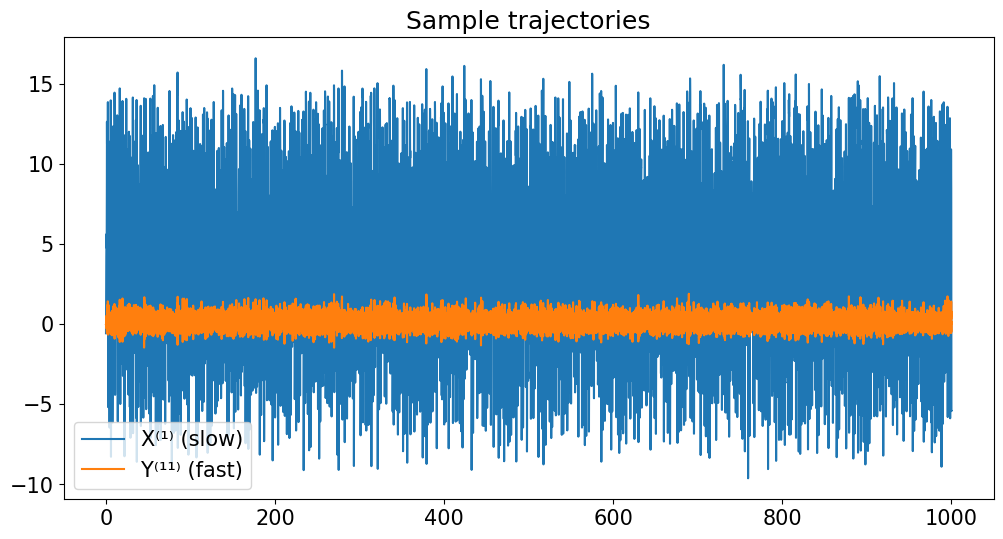

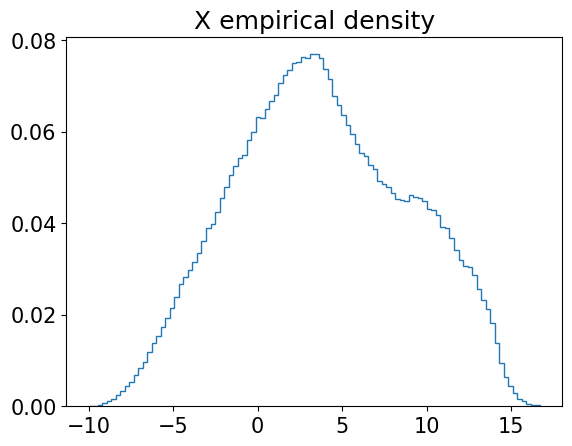

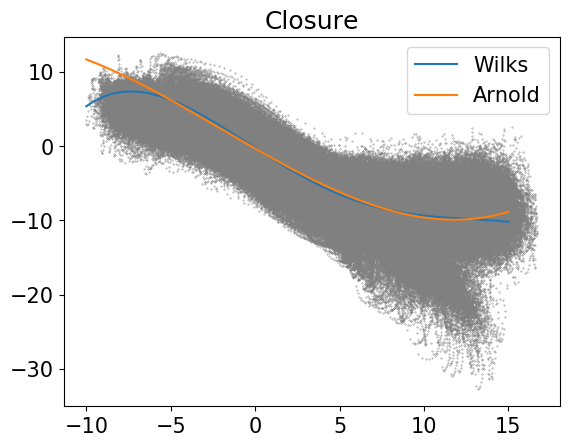

In [3]:
K,  J = 8, 32
F,  h, c, b = 20.0, 1.0, 10.0, 10.0
d = b
T, Δt, RK_order = 1000.0, 0.005, 4
obs_type, obs_p = "Statistics", 4
N_θ = 0
# Setup simulation parameters
s_param = Setup_Param(N_θ, K, J, F, h, c, b, d,
                      T, Δt, RK_order, 
                      obs_type, obs_p) 


T, N_t, Δt = s_param.T, s_param.N_t, s_param.Δt
ts = Array(LinRange(0, T, N_t+1)) 
K, J = s_param.K, s_param.J

# Initialization
Random.seed!(42);
Q0_ref = [rand(Normal(0, 1.0), K) ; rand(Normal(0, 0.01), K*J)]

# Run Multiscale Lorenz96
Qs_ref = run_Lorenz96(s_param, Q0_ref)
# Visulization
figure(figsize=(12,6))
plot(ts, Qs_ref[1, :], label = "X⁽¹⁾ (slow)")
plot(ts, Qs_ref[K+1, :], label = "Y⁽¹¹⁾ (fast)")
legend()
title("Sample trajectories")

figure(2) # hist
hist(Qs_ref[1:K,:][:], bins = 100, density = true, histtype = "step")
title("X empirical density")

figure(3)
h, c, d = s_param.h, s_param.c, s_param.d
X = (Qs_ref[1:K, :])[:]
Φ_ref = -h*c/d * sum(reshape(Qs_ref[K+1:end,:], J, K*size(Qs_ref, 2)), dims=1)
scatter(X, Φ_ref, s = 0.1, c="grey")
xs = Array(LinRange(-10, 15, 1000))

fwilks = -(0.262 .+ 1.45*xs - 0.0121*xs.^2 - 0.00713*xs.^3 + 0.000296*xs.^4)
plot(xs, fwilks, label="Wilks")

fAMP = -(0.341 .+ 1.3*xs - 0.0136*xs.^2 - 0.00235*xs.^3)
plot(xs, fAMP, label="Arnold")

legend()
title("Closure");
        

## Unscented Kalman inversion
The UKI is initialized with $\theta_0 \sim \mathcal{N}(0, I)$. 
The observation error is set to be $\eta = \mathcal{N}(0,\textrm{diag}\{0.05^2 y_{obs}\odot y_{obs}\})$, and we take $\alpha=1$, since the system is over-determined. Moreover, these simulations start with another random initialization of $X^{(k)} \sim \mathcal{N}(0,1)$. 

In [4]:
K,  J = 8, 32
F,  h, c, b = 20.0, 1.0, 10.0, 10.0
d = b
T, Δt, RK_order = 1000.0, 0.005, 4
obs_type, obs_p = "Statistics", 4

# Set up cubic Hermite polynomials
N_θ = 12
θ0_mean = zeros(Float64, N_θ)  #rand(Normal(0, 1), N_θ)                    # 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))           # standard deviation
Φ = ΦQP
N_iter = 20
α_reg = 1.0
update_freq = 0


# Setup simulation parameters
lorenz96_param = Setup_Param(N_θ, K, J, F, h, c, b, d,
                      T, Δt, RK_order, 
                      obs_type, obs_p) 


# Initialization
Random.seed!(42);
Q0_ref = [rand(Normal(0, 1.0), K) ; rand(Normal(0, 0.01), K*J)]
Q0 = rand(Normal(0, 1.0), K)

# Run Multiscale Lorenz96
Qs_ref = run_Lorenz96(lorenz96_param, Q0_ref)




y =  compute_obs(lorenz96_param, Qs_ref)
noise_level = 0.05
Random.seed!(123);
for i = 1:length(y)
    noise = rand(Normal(0, noise_level*y[i]))
    y[i] += noise
end
Σ_η = Array(Diagonal(noise_level^2*y.^2)) 




ukiobj = UKI_Run(lorenz96_param, (s_params,θ)->forward(s_params, θ, Q0, Φ), θ0_mean, θθ0_cov, y, Σ_η, α_reg, update_freq, N_iter)
# compute the solution with prior
Qs_prior = run_Lorenz96(lorenz96_param, Q0, θ0_mean, Φ)
# compute the solution with UKI results
Qs = run_Lorenz96(lorenz96_param, Q0, ukiobj.θ_mean[end], Φ);


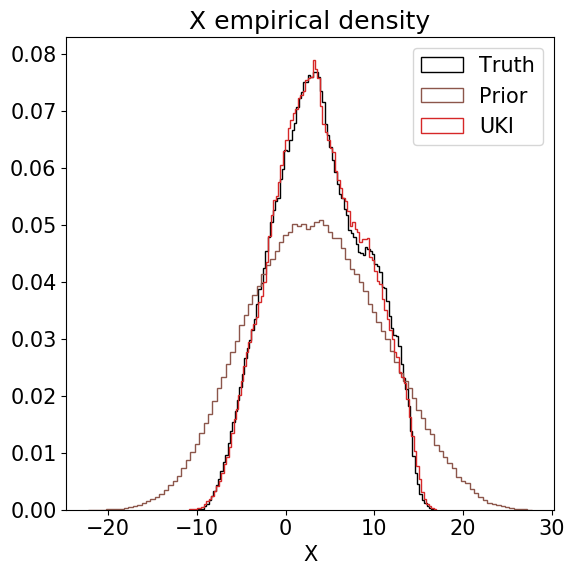

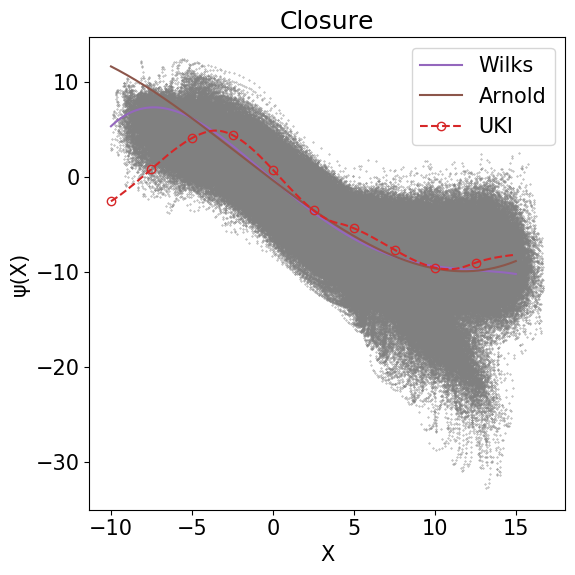

In [17]:
fig, ax = PyPlot.subplots(figsize=(6,6))
nbin = 100
ax.hist(Qs_ref[1:K, :][:], bins = nbin, color="black", density = true, histtype = "step", label="Truth")
ax.hist(Qs_prior[1:K, :][:], bins = nbin, color="C5", density = true, histtype = "step", label="Prior")
Qs = run_Lorenz96(s_param, Q0, ukiobj.θ_mean[end], Φ)
ax.hist(Qs[1:K, :][:], bins = nbin, color="C3", density = true, histtype = "step", label="UKI")
ax.set_xlabel("X")
ax.legend()
ax.set_title("X empirical density")
fig.tight_layout()




fig, ax = PyPlot.subplots(figsize=(6,6))
h, c, d = s_param.h, s_param.c, s_param.d
X = (Qs_ref[1:K, :])[:]
Φ_ref = -h*c/d * sum(reshape(Qs_ref[K+1:end,:], J, K*size(Qs_ref, 2)), dims=1)
ax.scatter(X, Φ_ref, s = 0.1, c="grey")
xs = Array(LinRange(-10, 15, 1000))
fwilks = -(0.262 .+ 1.45*xs - 0.0121*xs.^2 - 0.00713*xs.^3 + 0.000296*xs.^4)
ax.plot(xs, fwilks, c="C4", label="Wilks")
fAMP = -(0.341 .+ 1.3*xs - 0.0136*xs.^2 - 0.00235*xs.^3)
ax.plot(xs, fAMP, c="C5", label="Arnold")
fDA = similar(xs)
for i = 1:length(xs);  fDA[i] = Φ(xs[i], ukiobj.θ_mean[end]); end
ax.plot(xs, fDA, c="C3", linestyle="--", marker="o", fillstyle="none", markevery=100, label="UKI")
ax.set_xlabel("X")
ax.set_ylabel("ψ(X)")
ax.legend()
ax.set_title("Closure")
fig.tight_layout()




